In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download -d msambare/fer2013

 55% 33.0M/60.3M [00:00<00:00, 178MB/s] 
100% 60.3M/60.3M [00:00<00:00, 204MB/s]


In [3]:
! unzip "/content/fer2013.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [4]:
import os
import shutil
shutil.rmtree('/content/train/disgust')
shutil.rmtree('/content/test/disgust')

In [5]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,Conv3D
import tensorflow as tf 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

In [6]:
num_classes = 6
img_rows,img_cols = 48,48
batch_size = 32
train_data_dir = '/content/train'
validation_data_dir = '/content/test'

In [7]:
train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,
					shear_range=0.15,
					zoom_range=0.2,
					width_shift_range=0.2,
					height_shift_range=0.2,
					horizontal_flip=True,
					fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					color_mode='rgb',
					target_size=(img_rows,img_cols),
					batch_size=batch_size,
					class_mode='categorical',
					shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
							validation_data_dir,
							color_mode='rgb',
							target_size=(img_rows,img_cols),
							batch_size=batch_size,
							class_mode='categorical',
							shuffle=True)

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [9]:
base_model=tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=None,
                                                   input_shape=(48,48,3), pooling="avg", classes=6)

# construct the head of the model that will be placed on top of the
# the base model
headModel = base_model.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.1)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=base_model.input, outputs=headModel)



94781440/94765736 [==============================] - 2s 0us/step


In [10]:
for layer in base_model.layers:
        layer.trainable=False

In [11]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=.0001), metrics=['accuracy'])

nb_train_samples = 28273 
nb_validation_samples = 7067
epochs=70

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
history=model.fit_generator(
                train_generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs,
                validation_data=validation_generator,
                validation_steps=nb_validation_samples//batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/70
883/883 [==============================] - 81s 77ms/step - loss: 1.7750 - accuracy: 0.2419 - val_loss: 1.7492 - val_accuracy: 0.2527
Epoch 2/70
883/883 [==============================] - 68s 77ms/step - loss: 1.7544 - accuracy: 0.2531 - val_loss: 1.7424 - val_accuracy: 0.2528
Epoch 3/70
883/883 [==============================] - 68s 77ms/step - loss: 1.7501 - accuracy: 0.2531 - val_loss: 1.7377 - val_accuracy: 0.2568
Epoch 4/70
883/883 [==============================] - 72s 82ms/step - loss: 1.7475 - accuracy: 0.2554 - val_loss: 1.7310 - val_accuracy: 0.2581
Epoch 5/70
883/883 [==============================] - 68s 77ms/step - loss: 1.7458 - accuracy: 0.2575 - val_loss: 1.7248 - val_accuracy: 0.2589
Epoch 6/70
883/883 [==============================] - 67s 76ms/step - loss: 1.7429 - accuracy: 0.2574 - val_loss: 1.7220 - val_accuracy: 0.2604
Epoch 7/70
883/883 [==============================] - 68s 77ms/step - loss: 1.7419 - accuracy: 0.2603 - val_loss: 1.7271 - val_accuracy:

In [13]:
model.save("lowLearningRate0001.h5")

In [14]:
import matplotlib.pyplot as plt

def plot_graphs(history):
    """
    Plot accuracy and loss graph
    Arguments:
        History: model history
    """

    # ACCURACY
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend(['accuracy', 'val_accuracy'])

    # Show figure
    plt.show()

    # LOSS
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend(['loss', 'val_loss'])

    # Show figure
    plt.show()

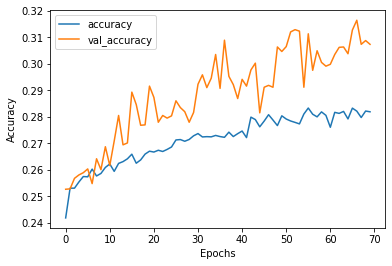

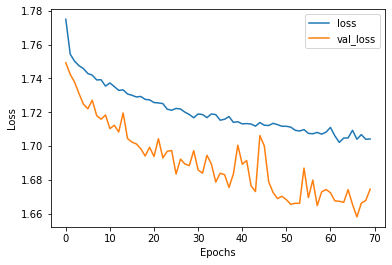

In [15]:
plot_graphs(history)